## Recipie Recommendation System - Content - Based 
### Exploratory analysis and prediction
### Alicja Wilk
#### Datalytics with Alicja 

# Data Preparation and Exploration

In [1]:
# checking cd
import os 
os.chdir ("/Users/alicjawilk/Desktop/datascience/projects/ml_projects/data/data")
print(os.getcwd())
#print(os.listdir(os.getcwd()))

/Users/alicjawilk/Desktop/datascience/projects/ml_projects/data/data


In [70]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.stem import PorterStemmer

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB as MNB
from sklearn.metrics import accuracy_score, r2_score, f1_score, confusion_matrix, precision_recall_fscore_support, roc_auc_score
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAD
from sklearn.ensemble import *

#custom feature dictionary vectors
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.word2vec import Word2Vec


In [3]:
n_row = None
df = pd.read_csv('core-data_recipe.csv',nrows = n_row)
nRow, nCol = df.shape
print(f"There are {nRow} rows, and {nCol} columns in the core data recipie file.")

n_row = None
df_test = pd.read_csv('core-data-test_rating.csv',nrows = n_row)
nRow, nCol = df_test.shape
print(f"There are {nRow} rows, and {nCol} columns in the test rating recipie file.")

n_row = None
df_train = pd.read_csv('core-data-train_rating.csv',nrows = n_row)
nRow, nCol = df_test.shape
print(f"There are {nRow} rows, and {nCol} columns in the train rating recipie file.")


There are 45630 rows, and 6 columns in the core data recipie file.
There are 283440 rows, and 4 columns in the test rating recipie file.
There are 283440 rows, and 4 columns in the train rating recipie file.


In [4]:
df.head(2)

,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name..."
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'..."


In [5]:
df_test.head(2)

,user_id,recipe_id,rating,dateLastModified
0,5215572,55090,5,2015-01-09T18:05:22.95\n
1,5215572,26317,4,2016-12-04T17:50:35.777\n


In [6]:
train_mean = df_train.groupby('recipe_id').rating.mean()
train_count = df_train.groupby('recipe_id').rating.count()
print(train_mean.head())
print(train_count.head())
print('Average # of recipes rated by users in training: ', train_mean.mean())

recipe_id
6663    4.315789
6664    4.375000
6665    3.666667
6666    4.696429
6667    4.333333
Name: rating, dtype: float64
recipe_id
6663    19
6664    16
6665    18
6666    56
6667    24
Name: rating, dtype: int64
Average # of recipes rated by users in training:  4.269739317278455


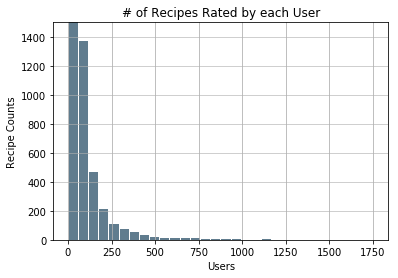

In [7]:
#Plotting # of receipes rated by users in a histogram
train_count.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('# of Recipes Rated by each User')
plt.xlabel('Users')
plt.ylabel('Recipe Counts')
plt.ylim([0, 1500])
plt.grid(axis='y', alpha=0.75)

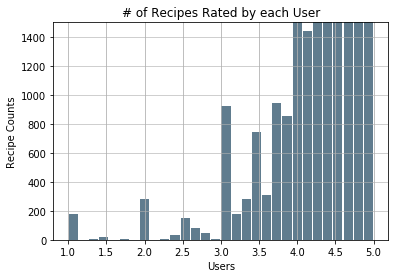

In [8]:
train_mean.plot.hist(grid=True, bins=30, rwidth=0.9,
                   color='#607c8e')
plt.title('# of Recipes Rated by each User')
plt.xlabel('Users')
plt.ylabel('Recipe Counts')
plt.ylim([0, 1500])
plt.grid(axis='y', alpha=0.75)

#### Adding Features to Recipes
* Average rating per recipe
* Count of # of ratings for each recipe

In [9]:
df = pd.merge(df, train_mean, how = 'outer', on = 'recipe_id')
df = pd.merge(df, train_count, how = 'outer', on = 'recipe_id')
df = df.fillna(train_mean.mean())
df.rename(columns={'rating_x':'avg_rating',
                          'rating_y':'count',
                          },inplace=True)
print(df.shape)
df.head(3)

(45630, 8)


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.269739,4.269739
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...",5.000000,1.000000
2,87211,Chicken Pesto Paninis,https://images.media-allrecipes.com/userphotos...,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...",4.617647,34.000000


#### Weighted Rating per  Recipe
* Adding a weighted rating for the average recipes which factors in the number of ratings that were used to determine that rating
* This increases average ratings for receips with higher counts and lowers average ratings for those recipes with few counts.

In [10]:
recipec = df['avg_rating'].mean()
recipem = df['count'].quantile(.9)
print(recipec)
print(recipem)

4.269739317278004
33.0


In [11]:
def weighted_rating(x, m=recipem, c=recipec):
    v = x['count']
    R = x['avg_rating']
    
    return (v/(v+m) * R) + (m/(m+v) * c)

In [12]:
df['weighted_rating'] = df.apply(weighted_rating, axis = 1)
df.head(2)

,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count,weighted_rating
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.269739,4.269739,4.269739
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...",5.000000,1.000000,4.291218


# Feature Engineering (continued)
II.  Ingredients

* Begin by identifying key singular ingredients, in the ingredients column, that are two words and combine the words with a hyphen. For example, "olive oil" will be converted to "olive-oil." 

In [13]:
def hyphenate_ingredients(df):
    df['ingredients'].replace(regex=r'baking soda',value='baking-soda',inplace=True)
    df['ingredients'].replace(regex=r'baking powder',value='baking-powder',inplace=True)
    df['ingredients'].replace(regex=r'sesame seeds',value='sesame-seeds',inplace=True)
    df['ingredients'].replace(regex=r'simple syrup',value='simple-syrup',inplace=True)
    df['ingredients'].replace(regex=r'olive oil',value='olive-oil',inplace=True)
    df['ingredients'].replace(regex=r'corn starch',value='corn-starch',inplace=True)
    df['ingredients'].replace(regex=r'garam masala',value='garam-masala',inplace=True)
    df['ingredients'].replace(regex=r'balsamic vinegar',value='balsamic-vinegar',inplace=True)
    df['ingredients'].replace(regex=r'sour cream',value='sour-cream',inplace=True)
    df['ingredients'].replace(regex=r'red bell pepper',value='red bell-pepper',inplace=True)
    df['ingredients'].replace(regex=r'green bell pepper',value='green bell-pepper',inplace=True)
    df['ingredients'].replace(regex=r'garam masala',value='garam-masala',inplace=True)
    df['ingredients'].replace(regex=r'peanut butter',value='peanut-butter',inplace=True)
    df['ingredients'].replace(regex=r'cream cheese',value='cream-cheese',inplace=True)
    df['ingredients'].replace(regex=r'garlic powder',value='garlic-powder',inplace=True)
    
  
    return df

In [14]:
df = hyphenate_ingredients(df)
df.head(2)

,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count,weighted_rating
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.269739,4.269739,4.269739
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...",5.000000,1.000000,4.291218


#### Cleaning the ingredients list

Now we will clean the test in the "ingredients" column. First we create a new column called 'new_ingredients' to update and place the cleaned ingredients text. To clean the ingredients text, we will create a function called "cleanIngredients" with the Recipe dataframe as the argument.

Steps to clean ingredients text (using regex):
* Take out all uneccessary punctuation or special characters and replace with a space
* Remove all parenthetical phrases. E.g. "(ounces)" 
* Remove all "&"
* Remove all words that preceed a ":". These words tend to be a header for sub-ingredients. E.g. "Sauce: heavy whipping cream, butter, minced garlic, grated Parmesan cheese"
* Convert all text to lowercase characters

In [15]:
df['ingredients_new'] = df['ingredients']

In [16]:
def cleanIngredients(df):
    df['ingredients_new'] = df['ingredients_new'].str.replace(r"[^A-Za-z0-9,\(\):!?@\'\`\"\_\n\^\-]", " ")
    df['ingredients_new'] = df['ingredients_new'].str.replace(r"(\(([\w\s-]*)\))", "")
    df['ingredients_new'] = df['ingredients_new'].str.replace(r"&","")
    df['ingredients_new'] = df['ingredients_new'].str.replace(r"\^[A-Za-z\s]+:|^[A-Za-z\s]+:\^","")
    df['ingredients_new'] = df['ingredients_new'].str.replace(r"[0-9]\s*[0-9]+ | [0-9]+\-"," ")
    df['ingredients_new'] = df['ingredients_new'].str.lower()
    
    return df

In [17]:
# Use the function to remove the extraneous items in the ingredients list
df = cleanIngredients(df)

#### Cleaning the ingredients list (continued)
* Remove the " ^ " character that is splitting the words
* Tokenize the cleaned-up ingredients for preprocessing for vectorization later on

In [18]:
# Split the ingredients using the '^' delimiter that existed
df['ingredients_new'] = df['ingredients_new'].str.split("^", )
df.head()

# function to tokenize words within list pased in
def tokenizeList(l):
    new_l = [val.split(" ") for val in l]
    flat_l = [item for sublist in new_l for item in sublist]
    return flat_l

#Apply tokenize function to cleaned ingredients
df['ingredientsTokenized'] = df['ingredients_new'].apply(tokenizeList)

# Feature Engineering (continued)

III.  Adding lengths of ingredients and of directions to receipe dataframe

In [19]:
# Creating a single string from the list of cleaned ingredients
df['ingredients'] = df['ingredients_new'].str.join(' ')
print(df['ingredients_new'].head())
print("\n")
print(df['ingredients'].head())

df['lengthDirections'] = df['cooking_directions'].apply(len)
df['lengthIngredients'] = df['ingredients'].apply(len)
df.head(2)

0    [sauerkraut drained, granny smith apples slice...
1    [chicken wings, sprigs rosemary, head garlic, ...
2    [focaccia bread quartered, prepared basil pest...
3    [red potatoes, strips bacon, heavy whipping cr...
4    [skinless boneless chicken breast halves, dice...
Name: ingredients_new, dtype: object


0    sauerkraut drained granny smith apples sliced ...
1    chicken wings sprigs rosemary head garlic oliv...
2    focaccia bread quartered prepared basil pesto ...
3    red potatoes strips bacon heavy whipping cream...
4    skinless boneless chicken breast halves diced ...
Name: ingredients, dtype: object


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count,weighted_rating,ingredients_new,ingredientsTokenized,lengthDirections,lengthIngredients
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained granny smith apples sliced ...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.269739,4.269739,4.269739,"[sauerkraut drained, granny smith apples slice...","[sauerkraut, drained, granny, smith, apples, s...",833,182
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings sprigs rosemary head garlic oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...",5.000000,1.000000,4.291218,"[chicken wings, sprigs rosemary, head garlic, ...","[chicken, wings, sprigs, rosemary, head, garli...",936,78


In [20]:
#Conversion function used to convert hours:minutes to total minutes
# and had to account for cases where one, the other or both exist
def TimeConvert(time1,time2):
    HorM = ''
    if time2 != 0:
        HorM = re.search(r'[h,m]',time2).group()
        time2 = re.search(r'\d+', time2).group()
        if time1 != 0:
            time1 = re.search(r'\d+', time1).group()
            return ((int(time1))*60+int(time2))
        else:
            if HorM == 'm':
                return (time2)
            else:
                return (int(time2)*60)
    else: 
        return(0)

In [21]:
# RegEx to pull out Prep Times if they exist
def GetPrepTimes(directions):
    PrepTimeH=0 
    PrepTimeM=0 
    PrepTime=0
    try:
        PrepTimeM = re.search(r'(Prep\\n)(\d+\s[h])(\s\d+\s[m])|(Prep\\n)(\d+\s[m,h])', directions).group(5)
        if PrepTimeM == None:
            PrepTimeH = re.search(r'(Prep\\n)(\d+\s[h])(\s\d+\s[m])|(Prep\\n)(\d+\s[m,h])', directions).group(2)
            PrepTimeM = re.search(r'(Prep\\n)(\d+\s[h])(\s\d+\s[m])|(Prep\\n)(\d+\s[m,h])', directions).group(3)
    except: 
        pass
    else:
        PrepTime = TimeConvert(PrepTimeH,PrepTimeM)
  
    return(PrepTime)

# RegEx to pull out Cook Times if they exist
def GetCookTimes(directions):
    CookTimeH=0 
    CookTimeM=0 
    CookTime=0
    try:
        CookTimeM = re.search(r'(Cook\\n)(\d+\s[h])(\s\d+\s[m])|(Cook\\n)(\d+\s[m,h])', directions).group(5)
        if CookTimeM == None:
            CookTimeH = re.search(r'(Cook\\n)(\d+\s[h])(\s\d+\s[m])|(Cook\\n)(\d+\s[m,h])', directions).group(2)
            CookTimeM = re.search(r'(Cook\\n)(\d+\s[h])(\s\d+\s[m])|(Cook\\n)(\d+\s[m,h])', directions).group(3)
    except: 
        pass
    else:
        CookTime = TimeConvert(CookTimeH,CookTimeM)
    
    return(CookTime)

# RegEx to pull out ReadyIn Times if they exist
def GetReadyInTimes(directions):
    ReadyInTimeH=0 
    ReadyInTimeM=0 
    ReadyInTime=0
    try:
        ReadyInTimeM = re.search(r'(Ready\sIn\\n)(\d+\s[h])(\s\d+\s[m])|(Ready\sIn\\n)(\d+\s[m,h])', directions).group(5)
        if ReadyInTimeM == None:
            ReadyInTimeH = re.search(r'(Ready\sIn\\n)(\d+\s[h])(\s\d+\s[m])|(Ready\sIn\\n)(\d+\s[m,h])', directions).group(2)
            ReadyInTimeM = re.search(r'(Ready\sIn\\n)(\d+\s[h])(\s\d+\s[m])|(Ready\sIn\\n)(\d+\s[m,h])', directions).group(3)
    except: 
        pass
    else:
        ReadyInTime = TimeConvert(ReadyInTimeH, ReadyInTimeM)

    return(ReadyInTime)

In [22]:
#Adding columns to recipe dataframe by calling funtions above
df['PrepTime']= df['cooking_directions'].apply(GetPrepTimes)
df['CookTime']= df['cooking_directions'].apply(GetCookTimes)
df['ReadyInTime']= df['cooking_directions'].apply(GetReadyInTimes)
print(df.shape)
df.head(2)

(45630, 16)


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count,weighted_rating,ingredients_new,ingredientsTokenized,lengthDirections,lengthIngredients,PrepTime,CookTime,ReadyInTime
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained granny smith apples sliced ...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.269739,4.269739,4.269739,"[sauerkraut drained, granny smith apples slice...","[sauerkraut, drained, granny, smith, apples, s...",833,182,15,150,165
1,218939,Foolproof Rosemary Chicken Wings,https://images.media-allrecipes.com/userphotos...,chicken wings sprigs rosemary head garlic oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...",5.000000,1.000000,4.291218,"[chicken wings, sprigs rosemary, head garlic, ...","[chicken, wings, sprigs, rosemary, head, garli...",936,78,20,40,60


# Vectorizing Ingredients

* Using TfidfVectorizer to determine least valuable words to add those to the English stop words before using CountVectorizer and comparing unigram, bigram and combined (unigram & bigram) vectors

In [23]:
listCorpus = df['ingredients'].tolist()

vectorizer = TfidfVectorizer()
vectorizer.fit(listCorpus)
vector = vectorizer.transform(df['ingredients'])
max_value = vector.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

#Not as valuable - low tfidf
feature_names = np.array(vectorizer.get_feature_names())
print("\nFeatures with the lowest tfidf:\n{}".format(feature_names[sorted_by_tfidf[:20]]))

#Frequently unique, high tfidf
print("\nFeatures with the highest tfidf:\n{}".format(feature_names[sorted_by_tfidf[-20:]]))

#idf score low, less importand
sorted_by_idf = np.argsort(vectorizer.idf_)
print("\nFeatures with the lowest idf:\n{}".format(feature_names[sorted_by_idf[:20]]))

#highest idf
print("\nFeatures with the highest idf:\n{}".format(feature_names[sorted_by_idf[-20:]]))


Features with the lowest tfidf:
['proverbs' '22' '21' 'jeremiah' 'leviticus' '20' 'isaiah' '14' 'cutting'
 'discos' 'canilla' 'salsita' 'sazonador' 'total' 'azafran' 'alcaparrado'
 'blackeye' 'myers' 'magazine' 'duct']

Features with the highest tfidf:
['cantaloupe' 'cranberry' 'semolina' 'tortillas' 'radishes' 'ear'
 'lingonberries' 'pumpkin' 'mussels' 'tongue' 'livers' 'mccormick' 'goya'
 'polenta' 'gari' 'egg' 'almonds' 'eggs' 'oranges' 'bacon']

Features with the lowest idf:
['salt' 'pepper' 'ground' 'sugar' 'white' 'chopped' 'oil' 'butter'
 'garlic' 'onion' 'and' 'black' 'cheese' 'flour' 'fresh' 'all' 'purpose'
 'to' 'powder' 'water']

Features with the highest idf:
['churned' 'ghosts' 'cheeses' 'simmered' 'chorize' 'chopsticks' 'chopin'
 'partridge' 'giblet' 'chong' 'sit' 'siu' 'gills' 'sixths' 'cholesterol'
 'glaces' 'chlorinated' 'pared' 'gianduja' 'lingcod']


In [24]:
# manually adding particular stop words from idf

custom_sw = ['chopped', 'fluid', 'ounce', 'ounces', 'inch', 'thick', 'plus', 'more', 
                   'taste', 'can', 'sliced', 'diced', 'toasted', 'thinly',
                  'ground', 'fresh', 'cubed', 'peeled', 'beaten', 'bottle', 'crushed', 'drained', 
                   'crumbled', 'stemmed', 'dice', 'cube', 'land','lakes', 'heinz', 'minced', 'mix',
                   'cut', 'with', 'for', 'inch', 'chop', 'slice', 'dice', 'toast', 'crush', 'peel', 'crumble', 
                  'stem', 'cube', 'husk', 'mince','abov', 'afterward', 'alon', 'alreadi', 'alway',
       'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 
       'becaus', 'becom', 'befor', 'besid', 'bottl', 'chees', 'cri', 
       'crumbl', 'describ', 'drain', 'dri', 'dure', 'els', 'elsewher', 
       'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 
       'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 
       'lake', 'latterli', 'mani', 'meanwhil', 'minc', 'moreov', 'mostli', 'nobodi', 
       'noon', 'noth', 'nowher', 'oliv', 'onc', 'onli', 'otherwis', 'ounc', 'ourselv', 
       'perhap', 'pleas', 'plu', 'sauc', 'seriou', 'sever', 'shred', 'sinc', 'sincer',
       'sixti', 'someon', 'someth', 'sometim', 'somewher', 'tast', 'themselv', 'thenc', 
       'thereaft', 'therebi', 'therefor', 'thi', 'thinli', 'thu', 'togeth', 'twelv', 'twenti', 
       'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv',
                   'anywh', 'becau', 'chee', 'el', 'elsewh', 'everywh', 'ind', 'otherwi', 'plea', 'somewh']
for word in ENGLISH_STOP_WORDS:
    custom_sw.append(word) 
    
custom_sw = custom_sw + feature_names[sorted_by_idf[:30]].tolist()

print("Number of stop words: " + str(np.shape(custom_sw)[0]))
print("Sample of stop words: ")
print(custom_sw[-20:])

Number of stop words: 499
Sample of stop words: 
['and', 'black', 'cheese', 'flour', 'fresh', 'all', 'purpose', 'to', 'powder', 'water', 'taste', 'milk', 'cream', 'eggs', 'olive', 'sauce', 'chicken', 'green', 'vanilla', 'red']


# Bag of Words  and Cluster Processing

* We created vectors using CountVectorizer and explored unigram, bigrams and combined before settling on the combined.  
* After that, we also stemmed the ingredients before generating a stemmed version of CountVectorizer that we use to generate kMeans clusters after running elbow chart to determine optimal # of clusters

In [25]:
cv = CountVectorizer(stop_words = custom_sw, ngram_range = (1,2))
unigram = (1,1)
bigram = (2,2)
combined = (1,2)
vectorizers = [unigram, bigram, combined]
counts = cv.fit_transform(df["ingredients"])  # sparse matrix with columns corresponding to words
words = cv.get_feature_names()  

k= 1 done, inertia: 1086548.1491272561
k= 2 done, inertia: 1086523.2370469798
k= 3 done, inertia: 1086144.4291061563
k= 4 done, inertia: 1086352.4888301166
k= 5 done, inertia: 1086398.5127111515
k= 6 done, inertia: 1084687.731048163
k= 7 done, inertia: 1061581.7567858025
k= 8 done, inertia: 1067675.2069408204
k= 9 done, inertia: 1082078.1538496893
k= 10 done, inertia: 1055718.6647661156
k= 11 done, inertia: 1074802.7689983852
k= 12 done, inertia: 1049123.1033398304
k= 13 done, inertia: 1051647.0547668685
k= 14 done, inertia: 1054401.0298961923


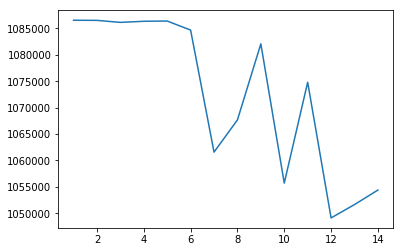

In [26]:
# Elbow chart generation used to determine optimal # of clusters
np.random.seed(345)
inertias = []
krange = range(1,15)
for k in krange:
    tclusterer = sklearn.cluster.MiniBatchKMeans(k, init_size=k+1)
    tclusterer.fit_predict(counts)
    inertias.append(tclusterer.inertia_)
    print('k=',k,'done, inertia:', tclusterer.inertia_)
plt.plot(krange, inertias)

### Choosing best 'n-grams' for  clustering
* Unigrams
* Bigrams
* Combined
* We chose combined 
    + ngram_range = (1,2)

In [27]:
for gram in vectorizers:
    print('This is: ' + str(gram))
    cv= CountVectorizer(stop_words = custom_sw, ngram_range = gram)
    counts = cv.fit_transform(df["ingredients"])  #sparse matrix with columns corresponding to words
    words = cv.get_feature_names() #array with words corresponding to columns
    print("Number of Attribute Words (Not Stemmed): " + str(np.shape(words)[0]))
    
    n=7
    km = KMeans(n_clusters = n)
    km.fit(counts)
  
    print("Top terms per cluster:")
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    terms = cv.get_feature_names()
    for i in range(n):
        top_ten_words = [terms[ind] for ind in order_centroids[i, :20]]
        print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))
        print('\n')

This is: (1, 1)
Number of Attribute Words (Not Stemmed): 3718
Top terms per cluster:
Cluster 0: shredded cheddar beef mozzarella sour bell cooked large parmesan grated frozen tomatoes onions bread potatoes corn soup beans bacon tomato


Cluster 1: large vegetable beef vinegar dry brown bell tomatoes egg onions potatoes bread grated frozen beans celery small broth tomato mustard


Cluster 2: juice lemon lime orange large zest grated pineapple cilantro frozen brown vinegar vegetable tomatoes bell egg ginger parsley dried ice


Cluster 3: baking soda extract brown cinnamon egg packed vegetable walnuts chocolate chips oats shortening nutmeg unsweetened buttermilk confectioners raisins cocoa wheat


Cluster 4: extract chocolate egg chips confectioners baking semisweet cinnamon brown coconut unsweetened heavy cocoa peanut syrup almond cake pie pecans instant


Cluster 5: boneless skinless breast halves vegetable broth dried bell soup shredded juice breasts grated lemon large mushrooms tomato

### Stemming
* Stemmed tokenized words using PorterStemmer to find the roots of each word in ingredients
* Updated the count vectorizer to use the custom stemmed tokenizer function

In [28]:
stemmer = PorterStemmer()
def customTokenizer2(document):
    document_list = document.split(" ")
    return [stemmer.stem(word) for word in document_list]

In [29]:
#Adjusted CountVectorizer for Stemming
cv2 = CountVectorizer(tokenizer=customTokenizer2, stop_words=custom_sw, ngram_range = (1,2))
#cv2 = CountVectorizer(tokenizer=customTokenizer2, stop_words=customStopWords, ngram_range = (1,1))
countsStemmed = cv2.fit_transform(df["ingredients"])
wordsStemmed = cv2.get_feature_names()  # array with words corresponding to columns
print("Number of Attribute Words (Not Stemmed): " + str(np.shape(words)[0]))
print("Number of Attribute Words (Stemmed): " + str(np.shape(wordsStemmed)[0]))

/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['egg', 'purpos'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Number of Attribute Words (Not Stemmed): 93092
Number of Attribute Words (Stemmed): 88195


# Feature Reduction #1:  SVD of CountVectorized stemmed vectors

* Used SVD to reduce CountVectorizer stemmed sparse features from over 500k to 300 to use with modeling

In [30]:
X = countsStemmed
svd_train, svd_test = train_test_split(X, test_size = 0.2, random_state = 747)


svd = TruncatedSVD(n_components=300)
svd.fit(countsStemmed)
countsStemmed_svd = svd.transform(countsStemmed)

print("Original shape: {}".format(str(countsStemmed.shape)))
print("Reduced shape: {}".format(str(countsStemmed_svd.shape)))

Original shape: (45630, 88195)
Reduced shape: (45630, 300)


# Feature Reduction # 2: word2vec 

* We generate tokens of words from ingredients in the train and test splits and for the full ingredients list of the recipe dataframe
* The full tokens are used to generate word vectors which are used to generate vector representations for the train, test and full recipe dataframes.



In [31]:
# Split into train, test
train_df, test_df = train_test_split(df, test_size = .3)
trainTokens = []
for s in train_df['ingredients'].tolist():
    trainTokens.append(gensim.utils.simple_preprocess(s))

    
testTokens = []
for s in test_df['ingredients'].tolist():
    testTokens.append(gensim.utils.simple_preprocess(s))

    
fullTokens = []
for s in df['ingredients'].tolist():
    fullTokens.append(gensim.utils.simple_preprocess(s))

In [32]:
#Generating word vectors; adjusted MIN_COUNT to 50, default was 10
model = Word2Vec(fullTokens, size=100, window=3, min_count=50, workers=4)
word_vectors = model.wv

In [33]:
word_vectors.most_similar_cosmul(['honey'])

[('molasses', 0.8145045638084412),
 ('nectar', 0.7698171138763428),
 ('asian', 0.7640025019645691),
 ('mirin', 0.7635637521743774),
 ('dijon', 0.7531182169914246),
 ('tahini', 0.7411420345306396),
 ('sake', 0.7368517518043518),
 ('dark', 0.7343244552612305),
 ('cornstarch', 0.7298605442047119),
 ('syrup', 0.7277550101280212)]

#### Generating w2v vectors based on word vectors based on words in the ingredients in train, test and the full recipe dataframes

In [34]:
train_w2v = np.zeros((len(df_train), word_vectors['pepper'].shape[0]))
idx = 0
for s in trainTokens:
    ws = []
    for w in s:
        if w in word_vectors:
            ws.append(w)
    if len(ws) is not 0:
        train_w2v[idx] = np.mean(word_vectors[ws], axis=0)
    idx += 1


test_w2v = np.zeros((len(df_test), word_vectors['pepper'].shape[0]))
idx = 0
for s in testTokens:
    ws = []
    for w in s:
        if w in word_vectors:
            ws.append(w)
    if len(ws) is not 0:
        test_w2v[idx] = np.mean(word_vectors[ws], axis=0)
    idx += 1
    
full_w2v = np.zeros((len(df), word_vectors['pepper'].shape[0]))
idx = 0
for s in fullTokens:
    ws = []
    for w in s:
        if w in word_vectors:
            ws.append(w)
    if len(ws) is not 0:
        full_w2v[idx] = np.mean(word_vectors[ws], axis=0)
    idx += 1

## Machine Learning Models

### Linear Regression

In [47]:
df['clusterID'] = km.fit_predict(countsStemmed_svd)
print(df.shape)
df.head(1)

(45630, 17)


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count,weighted_rating,ingredients_new,ingredientsTokenized,lengthDirections,lengthIngredients,PrepTime,CookTime,ReadyInTime,clusterID
0,240488,"Pork Loin, Apples, and Sauerkraut",https://images.media-allrecipes.com/userphotos...,sauerkraut drained granny smith apples sliced ...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.269739,4.269739,4.269739,"[sauerkraut drained, granny smith apples slice...","[sauerkraut, drained, granny, smith, apples, s...",833,182,15,150,165,3


In [50]:
X = df[['count', 'lengthDirections', 'lengthIngredients','PrepTime', 'CookTime',
           'ReadyInTime', 'clusterID']] #'cntUserRating','weightedUserRating']]
#Set up the dependent (Y)
y = df['avg_rating']
#y = df['weightedRecipeRating']
    
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2)
linReg = LinearRegression()
linReg = linReg.fit(X_train, y_train)

In [51]:
def run_linear_regression(df):
    lin_pred = linReg.predict(X_test)
    r2 = linReg.score(X_test, y_test)
    print("R-squared value: " + str(r2))
    linReg_mse = MSE(y_test, lin_pred)
    linReg_mad = MAD(y_test, lin_pred)
    print('Mean Squared Error {:.2f}'.format(linReg_mse))
    print('Mean Absolute Deviation {:.2f}'.format(linReg_mad))
    return(linReg)

In [53]:
run_linear_regression(df)
print(linReg.coef_)

R-squared value: 0.018195445766094887
Mean Squared Error 0.23
Mean Absolute Deviation 0.28
[ 1.16380971e-03  5.56686306e-08  3.42857320e-04  9.04178213e-04
 -2.55524888e-04  1.18081291e-04  1.64544455e-03]


### MultinominalNB

In [67]:
X_MNB = countsStemmed
#X_MNB = countsStemmed_svd

df['avg_ratingDiscrete'] = df['avg_rating'].round(0)
df['weighted_ratingDiscrete'] = df['weighted_rating'].round(0)

y_MNB = df['avg_ratingDiscrete']
X_trainMNB, X_testMNB, y_trainMNB, y_testMNB= train_test_split(X_MNB, y_MNB, test_size=0.2)
mnb = MNB(alpha=1.0, fit_prior=True, class_prior=None)

def run_MNB(df):
    mnb.fit(X_trainMNB, y_trainMNB)
    y_predMNB = mnb.predict(X_testMNB)
    y_predMNB = pd.Series(y_predMNB)
    MNB_mad = MAD(y_testMNB, y_predMNB)
    MNB_F1 = f1_score(y_testMNB, y_predMNB, average='weighted', labels=[1.0, 2.0, 3.0, 4.0, 5.0])
    #y_predDT = y_predDT.astype('category')
    print("Accuracy: " + str(accuracy_score(y_testMNB, y_predMNB)))
    print('Mean Absolute Deviation {:.2f}'.format(MNB_mad))
    print('F1 {:.3f}'.format(MNB_F1))
    print("Actual:\n",y_testMNB.head(5))
    print("Predicted:\n",y_predMNB.head(5))
    cm = confusion_matrix(y_testMNB, y_predMNB, labels=[1.0, 2.0, 3.0, 4.0, 5.0])
    print("Predicted Ratings-->\n",
      "['1'\t'2'\t'3'\t'4'\t'5']\n\n",cm)

In [68]:
run_MNB(df)

Accuracy: 0.6726934034626343
Mean Absolute Deviation 0.36
F1 0.649
Actual:
 12801    4.0
32280    4.0
41682    4.0
8160     4.0
3300     4.0
Name: avg_ratingDiscrete, dtype: float64
Predicted:
 0    4.0
1    4.0
2    4.0
3    4.0
4    4.0
dtype: float64
Predicted Ratings-->
 ['1'	'2'	'3'	'4'	'5']

 [[   0    0    0   15    4]
 [   0    0    0   77   28]
 [   0    0    1  238   78]
 [   0    0    5 5421 1115]
 [   0    0    0 1427  717]]


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [69]:
#BAGGING
bc = BaggingClassifier(base_estimator=mnb, n_estimators=300, n_jobs=-1)
bc.fit(X_trainMNB, y_trainMNB)
y_pred_bc = bc.predict(X_testMNB)
accuracy_bc = accuracy_score(y_testMNB, y_pred_bc)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy_bc))

Accuracy of Bagging Classifier: 0.676


## Model # 4:  **Decision Tree Classifier with Custom Features Vector** 

Because our models were not doing very well, we decided to create a custom feature vector to use that would incorporate our custom features regarding the length of ingredients, directions, the preparation times, and the cluster which would factor in the stemmed count vectorizers.  This was our most accurate model and the one we submitted to Kaggle.
    - Accuracy = 80.8%
    - MAD = .22
    - Predicted one 2, and all the rest 3's, 4's, and 5's
    
**Next steps** : perform Grid Search for Parameters that best fit our Decision Tree Models,hyperparameters corresponding to the best vectorizer score.

In [72]:
class CustomFeats(BaseEstimator, TransformerMixin):
    def __init__(self):
      self.feat_names = set()

    def fit(self, x, y=None):
        return self

    @staticmethod
    def features(recipe):
      return {
          'lenIngred' : (recipe['lengthIngredients']),
          'lenDirec' : (recipe['lengthDirections']),
          'Prep' : (recipe['PrepTime']),
          'Cook' : (recipe['CookTime']),
          'ReadyIn' : (recipe['ReadyInTime']),
          'AvgRating' : (recipe['avg_rating']),
          'CntRating' : (recipe['count']),
          'Cluster'  :  (recipe['clusterID']),
          'WeightedRating' : (recipe['weighted_rating'])
          
      }

    def get_feature_names(self):
        return list(self.feat_names)
      
    def transform(self, recipe):
      feats = []
      for index,row in recipe.iterrows():
        f = self.features(row)
        [self.feat_names.add(k) for k in f] 
        feats.append(f)
      return feats
    

feats = make_pipeline(CustomFeats(), DictVectorizer())
#feats = FeatureUnion([
#     ('custom', make_pipeline(CustomFeats(), DictVectorizer())),
#     ('tfidf', TfidfVectorizer(stop_words = customStopWords, ngram_range = (1,2)))])
#     ('bag_of_words', cv2)]) # or countsStemmed?
#    ('SVD', svd )]) # or countsStemmed_svd

In [86]:
X_DT = df[:]

y_DT = df['avg_ratingDiscrete'] #array of labels
X_trainDT, X_testDT, y_trainDT, y_testDT= train_test_split(X_DT, y_DT, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=8, random_state=1, max_features = "log2")
print(y_DT.unique())

X_trainDT.vecs = feats.fit_transform(X_trainDT)
X_testDT.vecs = feats.transform(X_testDT)
print(X_trainDT.vecs.shape, X_testDT.vecs.shape)

dt_model = make_pipeline(feats, dt)
dt_model.fit(X_trainDT, y_trainDT)



[4. 5. 3. 2. 1.]


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':
/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  del sys.path[0]


(36504, 157) (9126, 157)


Pipeline(memory=None,
     steps=[('pipeline', Pipeline(memory=None,
     steps=[('customfeats', CustomFeats()), ('dictvectorizer', DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
        sparse=True))])), ('decisiontreeclassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=...         min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best'))])

In [90]:
def run_decision_tree(df):
    
    y_predDT = dt_model.predict(X_testDT)
#    dt.fit(X_trainDT, y_trainDT)
#    y_predDT = dt.predict(X_testDT)
    y_predDT = pd.Series(y_predDT)
    DT_mad = MAD(y_testDT, y_predDT)
    DT_F1 = f1_score(y_testDT, y_predDT, average='weighted', labels=[1.0, 2.0, 3.0, 4.0, 5.0]) #average='macro' , average='micro', average='weighted', None
    #y_predDT = y_predDT.astype('category')
    print("Accuracy: " + str(accuracy_score(y_testDT, y_predDT)))
    print('Mean Absolute Deviation {:.2f}'.format(DT_mad))
    print('F1 {:.3f}'.format(DT_F1))
    print("Actual:\n",y_testDT.head(5))
    print("Predicted:\n",y_predDT.head(5))
    cm = confusion_matrix(y_testDT, y_predDT, labels=[1.0, 2.0, 3.0, 4.0, 5.0])
    print("Predicted Ratings-->\n",
      "['1'\t'2'\t'3'\t'4'\t'5']\n\n",cm)

In [91]:
run_decision_tree(df)

Accuracy: 0.8224852071005917
Mean Absolute Deviation 0.19
F1 0.785
Actual:
 39983    4.0
25725    5.0
44624    4.0
3195     4.0
11057    4.0
Name: avg_ratingDiscrete, dtype: float64
Predicted:
 0    4.0
1    4.0
2    4.0
3    4.0
4    4.0
dtype: float64
Predicted Ratings-->
 ['1'	'2'	'3'	'4'	'5']

 [[   0    0    0   31    0]
 [   0    0    0   96    0]
 [   0    0    0  340    1]
 [   0    0    1 6474   18]
 [   0    0    0 1133 1032]]


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


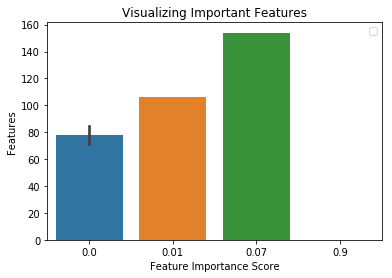

In [94]:
feature_imp = pd.Series(dt.feature_importances_).sort_values(ascending=False)
feature_imp = feature_imp.round(2)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Model # 5:  Decision Tree using word2vec
    - Accuracy = 70%
    - MAD = .31
    - Better distribution of predictions, more #'s but worse accuracy
    
    The Decision Tree Model would be improved if we split on the important features, it would also help to have cross validation here to help with the unbiased data. 

In [99]:
X_DT = full_w2v
y_DT = df['avg_ratingDiscrete'] #array of labels
X_trainDT, X_testDT, y_trainDT, y_testDT= train_test_split(X_DT, y_DT, test_size=0.2)
dt = DecisionTreeClassifier(max_depth=8, random_state=1, max_features = "log2")
print(y_DT.unique())

[4. 5. 3. 2. 1.]


In [100]:
def run_decision_tree(df):
    dt.fit(X_trainDT, y_trainDT)
    y_predDT = dt.predict(X_testDT)
    y_predDT = pd.Series(y_predDT)
    DT_mad = MAD(y_testDT, y_predDT)
    DT_F1 = f1_score(y_testDT, y_predDT, average='weighted', labels=[1.0, 2.0, 3.0, 4.0, 5.0]) #average='macro' , average='micro', average='weighted', None
    #y_predDT = y_predDT.astype('category')
    print("Accuracy: " + str(accuracy_score(y_testDT, y_predDT)))
    print('Mean Absolute Deviation {:.2f}'.format(DT_mad))
    print('F1 {:.3f}'.format(DT_F1))
    print("Actual:\n",y_testDT.head(5))
    print("Predicted:\n",y_predDT.head(5))
    cm = confusion_matrix(y_testDT, y_predDT, labels=[1.0, 2.0, 3.0, 4.0, 5.0])
    print("Predicted Ratings-->\n",
      "['1'\t'2'\t'3'\t'4'\t'5']\n\n",cm)

In [102]:
run_decision_tree(df)

Accuracy: 0.705347359193513
Mean Absolute Deviation 0.31
F1 0.613
Actual:
 45206    5.0
34143    4.0
18680    5.0
29613    5.0
20647    4.0
Name: avg_ratingDiscrete, dtype: float64
Predicted:
 0    4.0
1    4.0
2    4.0
3    4.0
4    5.0
dtype: float64
Predicted Ratings-->
 ['1'	'2'	'3'	'4'	'5']

 [[   0    0    0   26    1]
 [   0    0    0   73    9]
 [   0    0    0  315   12]
 [   0    0    1 6327  214]
 [   0    1    1 2036  110]]


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Bagging

Bagging improved accuracy to 72%
SG Boosting improved accuracy to 72% 

In [103]:

bc = BaggingClassifier(base_estimator=dt, n_estimators=300, n_jobs=-1)
bc.fit(X_trainDT, y_trainDT)
y_pred_bc = bc.predict(X_testDT)
accuracy_bc = accuracy_score(y_testDT, y_pred_bc)
print('Accuracy of Bagging Classifier: {:.3f}'.format(accuracy_bc))

Accuracy of Bagging Classifier: 0.717


## Stochastic Gradient Boosting


In [106]:
SEED = 1
sgbt = GradientBoostingClassifier(max_depth=1, 
                                 subsample=0.8,
                                 max_features=0.2, 
                                 n_estimators=300, 
                                 random_state=SEED)

sgbt.fit(X_trainDT, y_trainDT)
y_pred_sgbt = sgbt.predict(X_testDT)
print('Accuracy Stochastic Gradient Boosting: '+  str(accuracy_score(y_testDT, y_pred_sgbt)))


mad_test = MAD(y_testDT, y_pred_sgbt)
print('Test set MAD: {:.2f}'.format(mad_test))

Accuracy Stochastic Gradient Boosting: 0.7161954854262547
Test set MAD: 0.30


## Model # 6: Random Forest (based on DT using w2v)
    - Accuracy = 71%
    - MAD = .3

We set bootstrap to True which means that our samples are with replacement which is creating random samples. Creating random samples helps with overfitting. Also Random Forests are computionally faster which can be an advatage with our data set as well. 

**The next step:** split on the best features only, end include those features in our X split. This step would help with the noise. 



In [108]:
SEED = 1
rf = RandomForestClassifier(max_depth = 8, min_samples_leaf=0.12,random_state=SEED)
rf.fit(X_trainDT, y_trainDT)
y_pred_rf = rf.predict(X_testDT)
mse_test = MSE(y_testDT, y_pred_rf)
print("Accuracy: " + str(accuracy_score(y_testDT, y_pred_rf)))

RF_mad = MAD(y_testDT, y_pred_rf)
RF_F1 = f1_score(y_testDT, y_pred_rf, average='weighted', labels=[1.0, 2.0, 3.0, 4.0, 5.0]) #average='macro' , average='micro', average='weighted', None

print('Mean Absolute Deviation {:.2f}'.format(RF_mad))
print('F1 {:.3f}'.format(RF_F1))
print("Actual:\n",y_testDT.head(5))



/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy: 0.7168529476221784
Mean Absolute Deviation 0.30
F1 0.599
Actual:
 45206    5.0
34143    4.0
18680    5.0
29613    5.0
20647    4.0
Name: avg_ratingDiscrete, dtype: float64


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


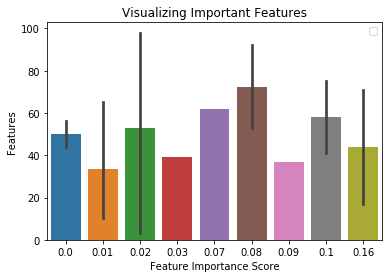

In [109]:
feature_imp = pd.Series(rf.feature_importances_).sort_values(ascending=False)
feature_imp = feature_imp.round(2)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

## Model #7:  Logistic Regression using SVD
    - Accuracy = 70%
    - MAD = .32

In [115]:
X_LR = countsStemmed_svd
y_LR = df['avg_ratingDiscrete'] 
X_trainLR, X_testLR, y_trainLR, y_testLR= train_test_split(X_LR, y_LR, test_size=0.2)
logr = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial', max_iter = 4000)


def run_logistic_regression(df):
    logr.fit(X_trainLR, y_trainLR)
    y_predLR = logr.predict(X_testLR)
    y_predLR = pd.Series(y_predLR)
    print(y_predLR.mean())
    LR_mad = MAD(y_testLR, y_predLR)
    LR_F1 = f1_score(y_testLR, y_predLR, average='weighted', labels=[1.0, 2.0, 3.0, 4.0, 5.0]) #average='macro' , average='micro', average='weighted', None
    print("Accuracy: " + str(accuracy_score(y_testLR, y_predLR)))
    print('Mean Absolute Deviation {:.2f}'.format(LR_mad))
    print('F1 {:.3f}'.format(LR_F1))
    print("Actual:\n",y_testLR.head(5))
    print("Predicted:\n",y_predLR.head(5))
    cm = confusion_matrix(y_testLR, y_predLR, labels=[1.0, 2.0, 3.0, 4.0, 5.0])
    print("Predicted Ratings-->\n",
      "['1'\t'2'\t'3'\t'4'\t'5']\n\n",cm)

In [118]:
run_logistic_regression(df)

4.030243261012492
Accuracy: 0.7081963620425159
Mean Absolute Deviation 0.32
F1 0.611
Actual:
 44643    4.0
21002    4.0
34975    4.0
27150    4.0
10585    4.0
Name: avg_ratingDiscrete, dtype: float64
Predicted:
 0    4.0
1    4.0
2    4.0
3    4.0
4    4.0
dtype: float64
Predicted Ratings-->
 ['1'	'2'	'3'	'4'	'5']

 [[   0    0    0   38    2]
 [   0    0    0  109    3]
 [   0    0    0  304   21]
 [   0    0    0 6334  123]
 [   0    1    0 2062  129]]


/Users/alicjawilk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Model # 8 Ensemble Model using w2v and SVD -  Voting Classifier : 
#### we will be evaluating classfiers
- LOGISTICS REGRESSION 
- DECISION TREE

    - Accuracy for w2v ensemble:  70% with .31 MAD

The problem here is that we cant use w2vec with MNB nor KNN because the model did not like the negative values that the model was creating

In [140]:
X = full_w2v
y = df['avg_ratingDiscrete']
SEED = 1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state= SEED)

In [139]:
X = full_w2v
y = df['avg_ratingDiscrete']
SEED = 1 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2,random_state= SEED)

classifiers = [('Logistic Regression', logr),
               ('Decision Tree', dt)]

for clf_name, clf in classifiers: #fit clf to the training set
    clf.fit(X_train.tolist(), y_train.tolist())
    y_pred = clf.predict(X_test.tolist())
# Evaluate the accuracy of clf on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy_score(y_test, y_pred)))

Logistic Regression : 0.708
Decision Tree : 0.703


In [141]:
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train, y_train)
y_pred = vc.predict(X_test)
a_s =accuracy_score(y_test, y_pred)
vc_mad = MAD(y_test, y_pred)
print(a_s)
print(vc_mad)

0.7086346701731318
0.31306158229235154


### Prediciton with DT

In [ ]:
vibsTest = pd.read_csv('test_10k_1.csv')
print(vibsTest.head())
print(vibsTest.shape)

In [127]:
new_test_dt = pd.merge(df, vibsTest, on ='recipe_id', how = 'inner')
#new_test_dt = new_test_dt.fillna
print(new_test_dt.shape)
new_test_dt.head()

(10000, 21)


,recipe_id,recipe_name,image_url,ingredients,cooking_directions,nutritions,avg_rating,count,weighted_rating,ingredients_new,...,lengthDirections,lengthIngredients,PrepTime,CookTime,ReadyInTime,clusterID,abg_ratingDiscrete,weighted_ratingDiscrete,avg_ratingDiscrete,user_id
0,22402,Cranberry Pork Chops II,https://images.media-allrecipes.com/userphotos...,pork chops fresh white sugar salt ground black...,{'directions': u'Prep\n25 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...",4.440000,25.0,4.343128,"[pork chops, fresh, white sugar, salt, ground ...",...,338,69,25,45,70,3,4.0,4.0,4.0,2003722
1,26668,Tater Tot Casserole III,https://images.media-allrecipes.com/userphotos...,ground beef condensed cream of mushroom soup f...,{'directions': u'Prep\n15 m\nCook\n30 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.073171,41.0,4.160830,"[ground beef, condensed cream of mushroom soup...",...,433,115,15,30,45,3,4.0,4.0,4.0,1684868
2,185816,Sweet Pork for Burritos,https://images.media-allrecipes.com/userphotos...,pork shoulder roast salsa fluid ounce) can bro...,{'directions': u'Prep\n30 m\nCook\n8 h\nReady ...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.571429,7.0,4.322535,"[pork shoulder roast, salsa, fluid ounce) can,...",...,513,112,30,480,510,3,5.0,4.0,5.0,1394676
3,8778,Cajun Chicken Pasta,https://images.media-allrecipes.com/userphotos...,linguine pasta skinless boneless chicken breas...,{'directions': u'Prep\n20 m\nCook\n20 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.717949,195.0,4.653076,"[linguine pasta, skinless boneless chicken bre...",...,680,245,20,20,40,2,5.0,5.0,5.0,2772033
4,8778,Cajun Chicken Pasta,https://images.media-allrecipes.com/userphotos...,linguine pasta skinless boneless chicken breas...,{'directions': u'Prep\n20 m\nCook\n20 m\nReady...,"{u'niacin': {u'hasCompleteData': False, u'name...",4.717949,195.0,4.653076,"[linguine pasta, skinless boneless chicken bre...",...,680,245,20,20,40,2,5.0,5.0,5.0,1169490


In [132]:
new_predDT = dt_model.predict(new_test_dt)
print(new_predDT[0:10,])

vibsTest['rating'] = new_predDT
vibsTest.head()

vibsTest['user_rep_id'] = vibsTest['user_id'].astype('str')+vibsTest['recipe_id'].astype('str')
vibsTest.head()

vibsTest.to_csv('user_recipe_predictions.csv')

[4. 4. 5. 4. 4. 4. 4. 4. 4. 4.]
